# 04. 비율 추정

In [1]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [2]:
from utils import set_pyplot_params
set_pyplot_params()

<br>

##  04.01. Euro Coin 문제

'**정보 이론, 추론, 알고리즘 학습**'에서 데이비드 맥케이는 다음의 문제를 제안

2002년 1월 4일 금요일, 가디언지에 다음과 같은 통계 기사가 게재

> 벨기에 1유로 동전을, 축을 중심으로 250번 회전을 시켰는데, 앞면이 140회, 뒷면은 110회가 나타남
> 런던 경제학교(LSE) 통계학 교수 배리 브라이트는 "매우 의심스럽다. 만약 동전이 한 쪽으로 기울어진 것이 아니라면, 결과가 이렇게 치우칠 확률은 7% 미만이다"

- 이 데이터가 동전이 한 쪽으로 기울었다는 것의 증거가 되는가?

<br>

두 가지의 단계가 필요
1. 이항분포를 사용해서 7%가 어디에서 나왔는지 탐색
2. 베이즈 정리를 사용해서 이 동전의 앞면이 나올 확률을 추정

<br>

## 04.02. 이항분포

만약 동전이 '공정하다' $\rightarrow$ 앞면이 나올 확률은 50%

동전을 2번 돌렸다면, 여기에 대응하는 결과는 `앞앞`, `앞뒤`, `뒤앞`, `뒤뒤` 4가지 이며, 각 25%의 확률을 가지고 있음

2번을 던져 앞면이 나온 횟수를 더해보면 0, 1, 2라는 경우의 수가 존재
- 0과 2의 경우 25%, 1의 경우는 50%의 확률


<br>

**보타 일반적으로 앞이 나올 확률을 $p$라고 하고, 동전을 $n$회 돌렸다고 가정할 때, 앞면이 총 $k$회 나올 확률은 이항분포를 따름**

$$\binom{n}{k} p^k (1-p)^{n-k}$$


**위 분포는 0부터 $n$사이 (0, $n$ 포함)의 임의의 수에 대한 분포로 $\binom{n}{k}$는 이항계수 이다**

<br>

- n = 2회의 동전을 던지고, 매 회 앞면이 나올 확률 p = 0.5라면, k = 1회 앞면이 나올 확률은

#### `scipy.stats.binom.pmf(k, n, p)` : 이항분포의 확률밀도함수

In [29]:
from scipy.stats import binom

In [30]:
n = 2
p = 0.5
k = 1

binom.pmf(k, n, p)

0.5000000000000002

<br>

- `bomom.pmf()`에 단일값 $k$대신 여러 값의 배열 사용 가능

In [31]:
import numpy as np
ks = np.arange(n+1)
ks

array([0, 1, 2])

In [32]:
ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

결과값으로 0, 1, 2회의 앞면이 나올 확률에 대한 numpy 배열이 출력 $\rightarrow$ **이 확률을 `Pmf()`에 넣으면, 결괏값으로 주어진 n과 p에 대한 k의 분포를 얻을 수 있음**

In [33]:
from empiricaldist import Pmf

In [34]:
pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


<br>

**다음 함수는 주어진 n과 p에 대한 이항분포를 구하여 이를 나타내는 `Pmf()`를 결괏값으로 반환**

In [61]:
def make_binomial(n, p):
    """이항 Pmf를 생성"""
    
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    
    return Pmf(ps, ks)

- `n=250`이고, `p=0.5` 일 때의 결과

In [36]:
pmf_k = make_binomial(n=250, p=0.5)

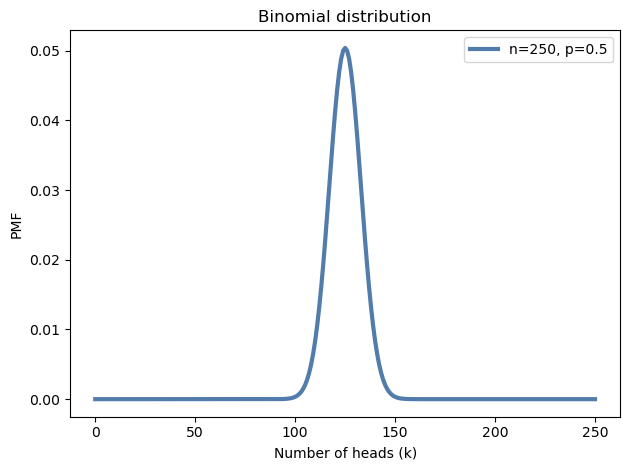

In [37]:
from utils import decorate

pmf_k.plot(label='n=250, p=0.5')
decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

- 이 분포의 MAP값은 125

In [38]:
pmf_k.max_prob()

125

- 하지만 이 값의 확률이 가장 크다고 해도, 125회의 앞면이 나올 확률은 5% 정도 밖에 안됨

In [39]:
pmf_k[125]

0.050412213147309655

- 하지만 맥케이의 문제에서는, 140회의 암ㅍ면이 나왔으며, 이 값이 나올 확률은 125회보다도 작다

In [40]:
pmf_k[140]

0.008357181724918204

- 맥케이가 언급한 내용에서, 통계학자는 "만약 동전이 한 쪽으로 기울어진 것이 아니라면, 결과가 이렇게 치우칠 확률은 7% 미만이다"라고 하였다

- 이항 분포를 사용해서 통계학자가 말한 내용을 확인해 볼 수 있다

- 다음함수는 PMF를 취해서 threshold보다 크거나 같은 값이 갖는 전체확률을 계산

In [62]:
def prob_ge(pmf, threshold):
    """threshold 보다 크거나 같은 값이 가지는 총 확률"""
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()

    return total

- 140개 이상의 앞면이 나올 확률은 약 3.3%

In [42]:
prob_ge(pmf_k, 140)
# pmf_k.prob_ge(140)

0.03321057562002164

- 이는 언급된 7%보다 작다
- 통계학자는 140처럼 '극단적인' 모든 값을 언급했으므로, 110보다 같거나 작은 경우 역시 포함했기 때문에 이런 차이가 발생

<br>

- 우선 앞면이 나올 횟수에 대한 기댓값은 125였으며,

    140이 나온 경우라면 기댓값보다 15회 더 많음
    
    만약, 110회 나왔다면, 기댓값보다는 15회 적다
    
<br>

**따라서 7%의 확률은 이 양쪽 '꼬리'를 합한 값**

In [43]:
import matplotlib.pyplot as plt

In [44]:
def fill_below(pmf):
    qs = pmf.index
    ps = pmf.values
    plt.fill_between(qs, ps, 0, color='C5', alpha=0.4)

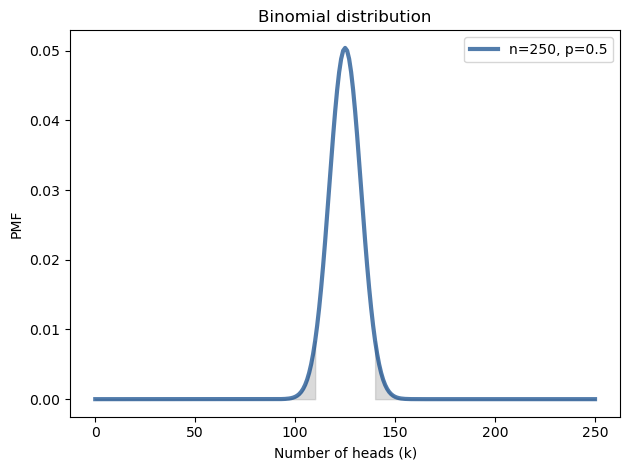

In [45]:
qs = pmf_k.index
fill_below(pmf_k[qs>=140])
fill_below(pmf_k[qs<=110])
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

In [46]:
pmf_k.prob_le(110)

0.03321057562002164

**결과가 110보다 작거나 같을 확률 역시 3.3%로, 140처럼 '극단적인'총 확률은 6.6% 이다**

**'동전이 공정하다면 극단적인 값은 나오지 않는다'라는 결론 도출**

<br>

## 04.03.Bayesian Estimation

어떤 동전이든 세워서 돌리면, 앞면을 보이며 넘어질 확률을 가진다.

이 확률을 $x$라고 할때, $x$는 무게 분산 등 물리적 특성에 영향을 받는다고 판단할 수 있다.

만약 동전의 무게가 완벽한 균형을 이루고 있다면, $x$는 50%에 근접하다고 생각하겠지만, 동전의 무게가 어느 한쪽에 치우쳐 잇다면, $x$는 이에 따라 달라진다.

<br>

- **우선 $x$의 모든 값이 동일한 정도로 가능하다고 가정하는 균등분포를 사전분포로 두고 시작**
    
    (앞면을 보이며 넘어질 확률이 $x$일 확률 = 1 / 101)

In [85]:
from fractions import Fraction

In [87]:
hypos = np.linspace(0, 1, 101)
prior = Pmf(Fraction(1, 101), hypos)
prior.head()

,probs
0.00,1/101
0.01,1/101
0.02,1/101


- 가능도 계산

In [88]:
likelihood_heads = hypos
likelihood_tails = 1 - hypos

In [89]:
print(likelihood_heads)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


- 앞면과 뒷면의 가능도를 딕셔너리 형태로 생성

In [90]:
likelihood = {
    'H': likelihood_heads,
    'T': likelihood_tails
}

- 앞면을 140번 반복하고, 뒷면을 110번 반복해서 문자열을 만들어 데이터를 표현

In [91]:
dataset = 'H' * 140 + 'T' * 110

- 갱신함수
    - 첫 번째 인자는 사전확률을 나타내는 `Pmf`, 두 번째 인자는 문자열 시퀀스
    - 함수가 진행되면서, `pmf`에 문자열의 결괏값에 따른 가능도를 곱해감

In [92]:
def update_euro(pmf, dataset):
    """주어진 H와 T의 문자열로 pmf를 갱신"""
    
    for data in dataset:
        pmf *= likelihood[data]
        pmf.normalize()

In [93]:
posterior = prior.copy()
update_euro(posterior, dataset)

- 동전 앞면의 비율 $x$에 대한 사후확률분포

In [94]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

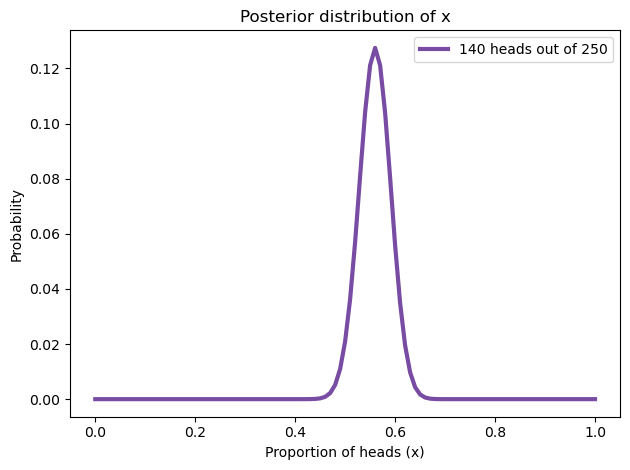

In [95]:
posterior.plot(label='140 heads out of 250', color='C4')
decorate_euro(title='Posterior distribution of x')

#### 사후확률분포는 데이터를 본 이후의 $x$에 대한 믿음을 나타냄
- 0.4보다 작거나, 0.7보다 큰 경우는 거의 없고, 0.5에서 0.6사이가 가장 가능성이 있음을 알 수 있음

- 실제 가장 가능성 있는 $x$의 값은 0.56 $\rightarrow$ 이는 데이터에서 앞면의 비율로 나왔던 140/250

In [96]:
posterior.max_prob()

0.56

<br>

## 04.04. 삼각사전분포
- 이전에 균등사전분포를 아래와 같이 사용하였음

In [99]:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

101

In [100]:
uniform.head()

,probs
0.00,0.009901
0.01,0.009901
0.02,0.009901


- 하지만 동전에 대해서 알고 있는 사전적 지식을 생각해보면, 이는 합리적이지 않음
- 만약 동전의 무게가 한 쪽으로 쏠려 있다면, $x$는 0.5에서 다소 벗어났을 수 있다
    - 그렇다고 해도 $x$가  0.1이나 0.9가 나올 정도로 벨기에 유로동전이 비뚤어져 있을 것이라고는 생각하기 어려움
    
<br>

- **$x$가 0.5에 가까울 수록 높고 극단적인 값으로 갈수록 낮은 확률을 갖는 사전분포를 선택하는게 합리적**

    $\rightarrow$ **삼각형 형태의 사전확률 고려 가능**

In [102]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33,
       32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16,
       15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [106]:
triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()
triangle.head()

,probs
0.00,0.0000
0.01,0.0004
0.02,0.0008


- **삼각사전분포 vs 균등사전분포**

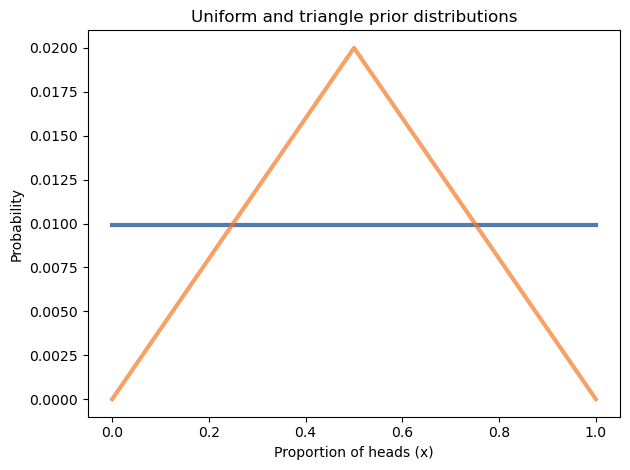

In [105]:
uniform.plot()
triangle.plot()
decorate_euro(title='Uniform and triangle prior distributions')

<br>

- 삼각사전분포와 균등분포를 통한 사전분포 갱신

In [107]:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

- 사후확률
    - 사후확률분포는 보기에 거의 차이가 나지 않고, 실제로 이 차이가 영향을 미치지 않음
    
**균등분포와 삼각분포 중 어느 사전확률이 더 나은지를 두고 논쟁을 하는 것은 의미가 없음**

<br>

**$\rightarrow$ 사전분포의 늪 (swamping the prior)의 하나의 예**
- **데이터가 충분하다면, 서로 다른 사전확률로 시작한다고 해도 동일한 사후확률로 수렴**

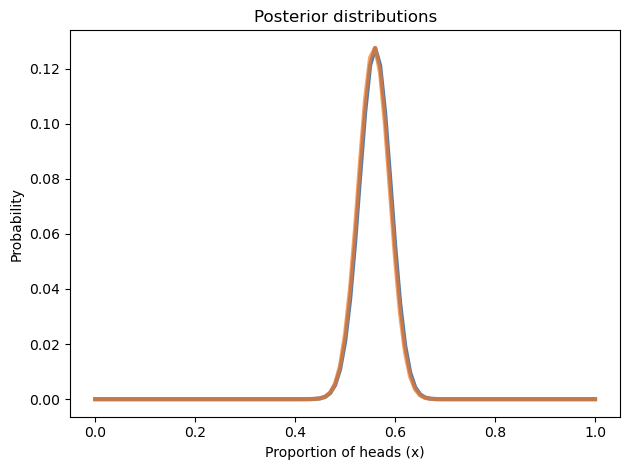

In [108]:
uniform.plot()
triangle.plot()
decorate_euro(title='Posterior distributions')

<br>

## 04.05. 이항가능도함수

이전에서, 한 번의 동전 시행이 한번의 갱신으로 이어졌음 (유료동전문제에서는 250번의 갱신)

이에 대한 효율적인 대안으로, 전체 데이터셋의 가능도를 한 번에 계산

x에 대한 각 가설 값에 대해, 250회 회전 후 140회 앞면이 나올 확률을 계산 

**$\rightarrow$ 이항분포 사용 (앞면이 나올 확률이 $p$일 때, $n$회 돌려서 앞면이 $k$번 나올 확률)**


$$\binom{n}{k} p^k (1-p)^{n-k}$$


In [109]:
from scipy.stats import binom

In [119]:
def update_binomial(pmf, data):
    """이항분포를 사용해서 pmf를 갱신"""
    k, n = data
    xs = pmf.qs
    
    # p가 각 xs값인 이항분포에서, 250회를 시행하여 앞면이 140번 나올 확률 (=각 xs값에 대한 가능도)
    likelihood = binom.pmf(k, n, xs) 
    pmf *= likelihood
    pmf.normalize()

In [118]:
uniform2 = Pmf(1/101, hypos, name='uniform2')
data = 140, 250
update_binomial(uniform2, data)

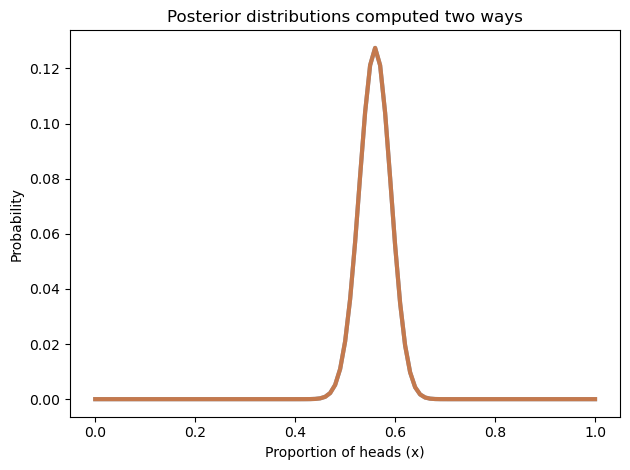

In [117]:
uniform.plot()
uniform2.plot()
decorate_euro(title='Posterior distributions computed two ways')

`np.allclose()`를 사용해서 매우 작은 소숫점 이하 부분은 반올림한 후 앞에서 구한 결과와 같은지 확인

In [113]:
np.allclose(uniform, uniform2)

True

<br>

## 04.06. 베이지안 통계

- 사전분포가 주관적임에 따라, 사후분포 역시 주관적
- 베이지안 방식의 확률 해석에 있어서는, 물리량을 임의의 상태로 두고 이에 대한 확률계산은 의미 있고 유용